In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from datetime import datetime
import scipy
import itertools
import geopandas as gpd
import xarray as xr
import regionmask
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/sara/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_19937/1413625899.py:8: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

Data from UEA CRU TS4.07 (1901-2022)

In [2]:
# file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\cru_ts4.07.1901.2022.tmx.dat.nc"
# file2 = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\cru_ts4.07.1901.2022.pre.dat.nc"
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.pre.dat.nc"
file2 = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.tmx.dat.nc"

file_paths_list =[file,file2]
monthly_forecast=xr.Dataset()

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)], compat='override')

Data on conflict events from ACLED

In [3]:
# file = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\ACLED_1997-01-01-2023-07-18_Somalia.csv"# df = pd.read_csv(file)
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/ACLED_1997-01-01-2023-07-18_Somalia.csv"
df = pd.read_csv(file)

Shapefile with administrative boundaries of Somalia

In [4]:
# path = r"C:\Users\PcLaptop\Documents\GitHub\Climate-and-conflict\Datasets\som_adm_ocha_itos_20230308_shp\som_admbnda_adm1_ocha_20230308.shp"
path = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp"
states_gdf = gpd.read_file(path) 

Limit the lat-lon and time

In [5]:
def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(states_gdf)

In [6]:
#monthly_forecast rename variables tmx to tmp
monthly_forecast = monthly_forecast.rename_vars({'tmx': 'tmp'})

In [7]:
start_date = '1901-01-01'
end_date = '2022-12-31'

region = monthly_forecast[["pre",'tmp']].sel(
    time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

In [8]:
region_mask = regionmask.mask_3D_geopandas(states_gdf,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

temp_pre = region.where(region_mask)

In [9]:
temp_pre = temp_pre.groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [10]:
replacement_dict = {0  :  'Awdal',
1    :         'Bakool',
2      :       'Banadir',
3      :         'Bari',
4       :         'Bay',
5        :  'Galgaduud',
6          :      'Gedo',
7          :   'Hiraan',
8   :       'Lower_Juba',
9   :   'Lower_Shabelle',
10  :      'Middle_Juba',
11   : 'Middle_Shabelle',
12    :          'Mudug',
13    :        'Nugaal',
14      :       'Sanaag',
15       :        'Sool',
16        :   'Togdheer',
17   : 'Woqooyi_Galbeed'}

temp_pre['admin1'] = temp_pre['region'].replace(replacement_dict)
df['admin1'] = df['admin1'].str.replace(' ', '_')
temp_pre.drop('region', axis=1, inplace=True)

In [11]:
# Modify event_date column to datetime

df['event_date'] = pd.to_datetime(df['event_date'])
df = df.set_index('event_date') 

In [12]:
conflict = df.groupby([pd.Grouper(freq='M'),"admin1"]).count()
conflict.reset_index(level=[0, 1], inplace=True)
conflict = conflict[['event_date','admin1','year']].rename(columns={'year': 'conflicts','event_date': 'time'})

# Aggregate the datetime objects by month
conf = conflict.groupby([pd.Grouper(key='time', freq='M'),'admin1'])['conflicts'].sum().to_frame()

In [13]:
# Reindex the DataFrame with all dates and districts and fill missing values with 0

dates = conf.index.get_level_values('time').unique()
districts = conf.index.get_level_values('admin1').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts], names=['time', 'admin1'])

conflicts = conf.reindex(all_combinations, fill_value=0).reset_index()    
conflicts = conflicts.sort_values(by=['time', 'admin1'], ascending=[True, True])
conflicts.reset_index(drop=True, inplace=True)

In [14]:
# Add Banadir region with tmp and pre as mean of the neighbouring regions

district1 = 'Lower_Shabelle'  
district2 = 'Middle_Shabelle'  

# Calculate the mean tmp and pre for the neighboring districts
mean_t = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['tmp'].mean()
mean_p = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['pre'].mean()

new_data = pd.DataFrame({ 'admin1': 'Banadir', 'tmp': mean_t, 'pre': mean_p}).reset_index()

# Append the new DataFrame to the original DataFrame
df3 = pd.concat([temp_pre, new_data])

temp_pre = df3.sort_values(by=['time', 'admin1'], ascending=[True, True]).reset_index(drop=True)

In [15]:
# Only keep month and year in time column in temp_pre and conflicts

temp_pre['time'] = pd.to_datetime(temp_pre['time']).dt.strftime('%Y-%m-%d')
temp_pre['month'] = temp_pre['time'].str[5:7]
temp_pre['month_year'] = temp_pre['time'].str[:7]
conflicts['time'] = conflicts['time'].dt.strftime('%Y-%m').values

temp_pre = temp_pre[['month_year','admin1','tmp','pre']]
temp_pre = temp_pre.rename(columns={'month_year':'time'})

In [16]:
# Split the dataframe into regions

reg=[]
for admin in temp_pre['admin1'].unique():
    a = temp_pre[temp_pre['admin1']==admin].reset_index(drop=True)
    reg.append(a)

In [17]:
# Calculate the TA (temperature anomaly), PA (precipitation anomaly) and DL (drought lenght) for each region

avg_t = avg_p = std_t = std_p = np.zeros(18)

for i in range(18):

    reg[i]['year'] , reg[i]['month'] = reg[i]['time'].str[:4] , reg[i]['time'].str[5:7]

    # TA
    mean_temp_i , std_temp_i  = reg[i].groupby('month')['tmp'].mean() , reg[i].groupby('month')['tmp'].std()
    reg[i]['avg_temp'] , reg[i]['std_temp']  = reg[i]['month'].map(mean_temp_i) , reg[i]['month'].map(std_temp_i)
    reg[i]['diff_t']= (reg[i]['tmp']-reg[i]['avg_temp'])/reg[i]['std_temp']
    reg[i]['TA'] = (reg[i]['diff_t'].shift(2) + reg[i]['diff_t'].shift(1) + reg[i]['diff_t'])/3

    # PA
    mean_pre_i , std_pre_i  = reg[i].groupby('month')['pre'].mean() , reg[i].groupby('month')['pre'].std()
    reg[i]['avg_pre'] , reg[i]['std_pre']= reg[i]['month'].map(mean_pre_i) , reg[i]['month'].map(std_pre_i)
    reg[i]['diff_p']= (reg[i]['pre']-reg[i]['avg_pre'])/reg[i]['std_pre']
    reg[i]['PA'] = (reg[i]['diff_p'].shift(2) + reg[i]['diff_p'].shift(1) + reg[i]['diff_p'])/3
    
    # DL 
    reg[i]['DL'] = 0
    mask = reg[i]['TA'] > 0
    group_id = (mask != mask.shift()).cumsum()             # Create a group identifier for each consecutive group
    count = reg[i].groupby(group_id).cumcount() + 1        # Calculate the count within each group
    reg[i]['DL'] = np.where(mask, count, 0)                # Assign the count values to the 'DL' column

    reg[i] = reg[i].reset_index()

In [23]:
temp_pre_c = pd.concat([reg[i] for i in range(18)], axis=0)
temp_pre_c = temp_pre_c.dropna()

# Select a subset of the dataframes from 1997-01 to 2009-12

start='1996-01'
end='2023-12'
temp_pre_97_09 = temp_pre_c[(temp_pre_c['time'] >= start) & (temp_pre_c['time'] <= end)]
conflicts_97_09 = conflicts[(conflicts['time'] >= start) & (conflicts['time'] <= end)]

df_c_97_09 = pd.merge(temp_pre_97_09, conflicts_97_09, on=['time','admin1'], how='outer')
df_c_97_09 = df_c_97_09.fillna(0)
df_c_97_09 = df_c_97_09[['time','admin1','TA','PA','DL','conflicts','pre']]
df_c_97_09 = df_c_97_09.sort_values(by=['time','admin1'], ascending=[True, True]).reset_index(drop=True)

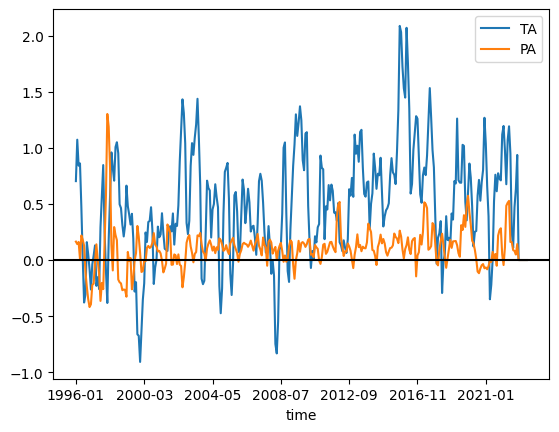

In [24]:
df_c_97_09.groupby(['time'])[['TA','PA']].mean().plot()
#plot hline in 0
plt.axhline(y=0, color='black', linestyle='-')


In [25]:
df_c_97_09
#subset df_c_97_09 from year 2021 to 2022
df_trial = df_c_97_09[(df_c_97_09['time'] >= '2021-01') & (df_c_97_09['time'] <= '2022-12')]
df_trial = df_trial.reset_index(drop=True)
df_trial


time           admin1        TA        PA    DL  conflicts       pre
0    2021-01            Awdal  2.134558 -0.260118   7.0        0.0  1.475000
1    2021-01           Bakool  0.900489 -0.390869  30.0       15.0  0.550000
2    2021-01          Banadir  0.752060  0.115564  27.0       52.0  5.915000
3    2021-01             Bari  0.919743  0.147504  28.0        5.0  4.045833
4    2021-01              Bay  1.162592 -0.444839  31.0       25.0  0.835714
..       ...              ...       ...       ...   ...        ...       ...
427  2022-12           Nugaal  0.461854  0.026329   2.0        1.0  3.780000
428  2022-12           Sanaag  1.309333  0.053770   3.0        0.0  1.261111
429  2022-12             Sool  1.087091  0.026107   3.0        8.0  0.441667
430  2022-12         Togdheer  1.649781 -0.004527   3.0        0.0  0.770000
431  2022-12  Woqooyi_Galbeed  1.866981 -0.141417  18.0        2.0  0.790000

[432 rows x 7 columns]

In [26]:
E anzi, questa settimana mi sono accorta di un problema nei dati di anomalie di precipitazione. Le ho calcolate a partire da un dataset di gridded precipitations (versione 4.07 delle UEA-CRU time-series), ma molte 

SyntaxError: invalid syntax (1772053379.py, line 1)

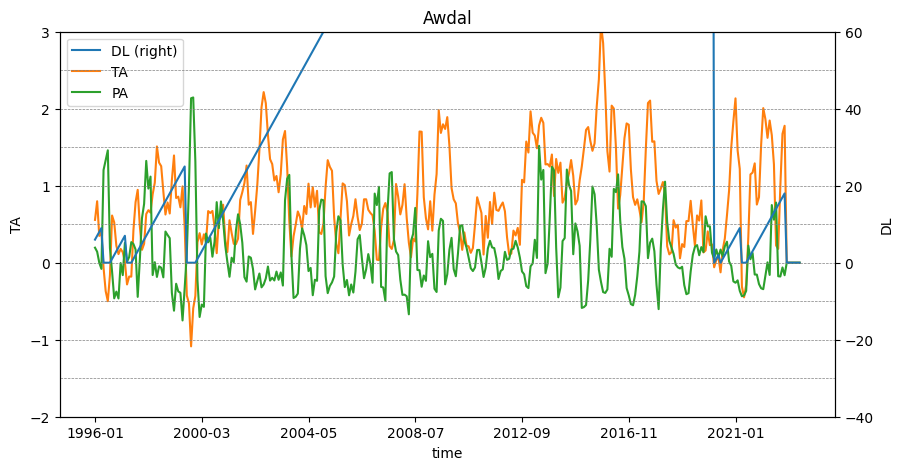

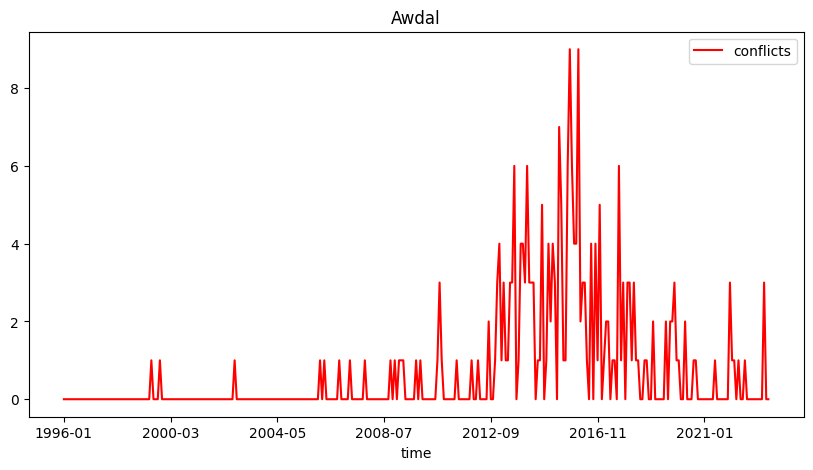

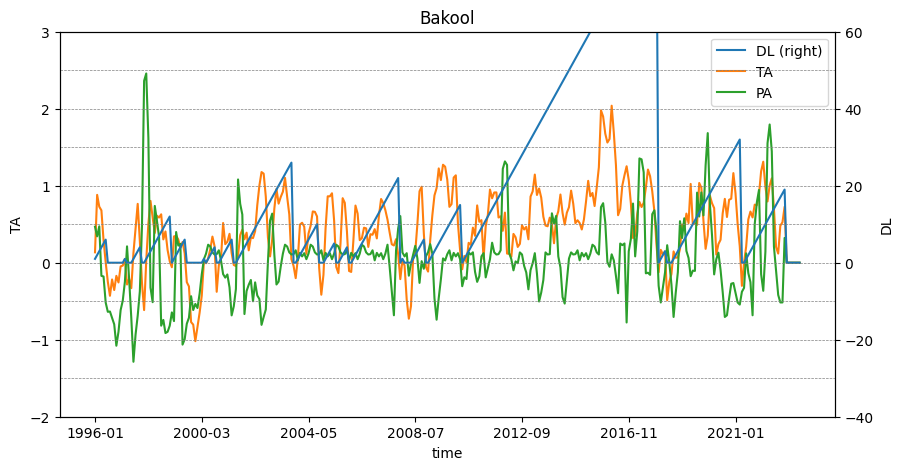

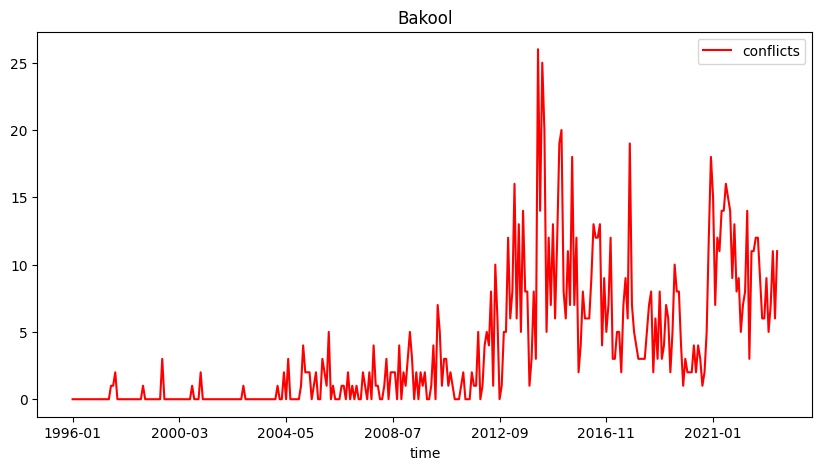

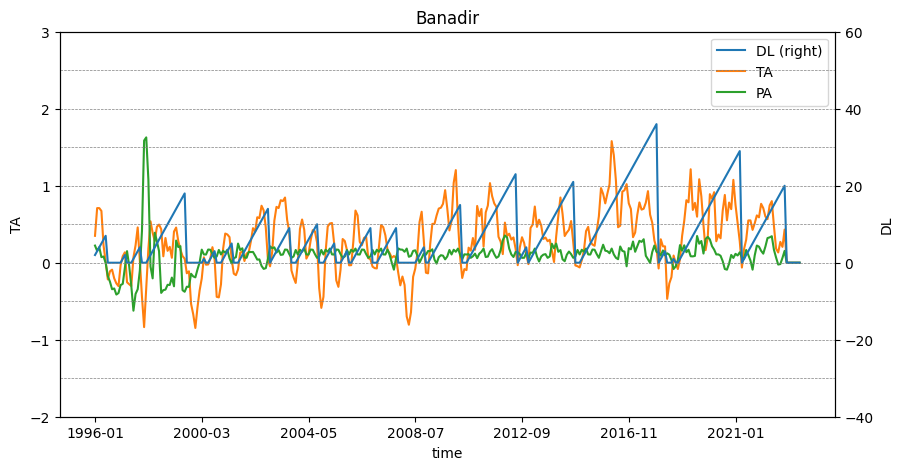

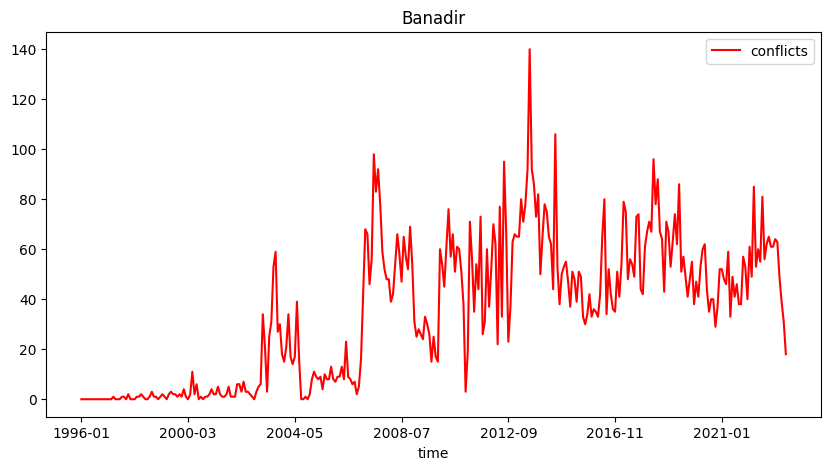

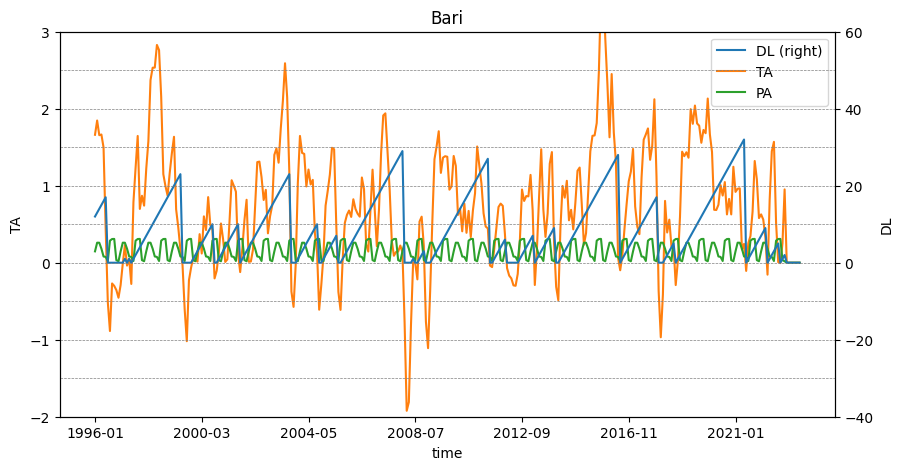

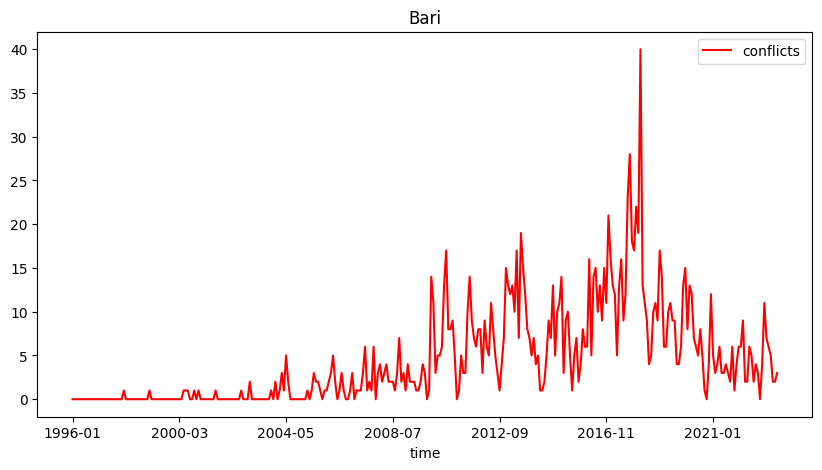

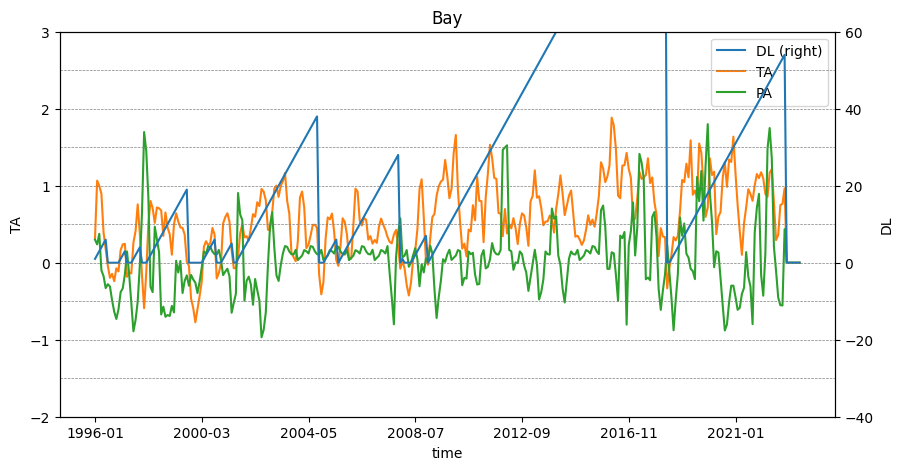

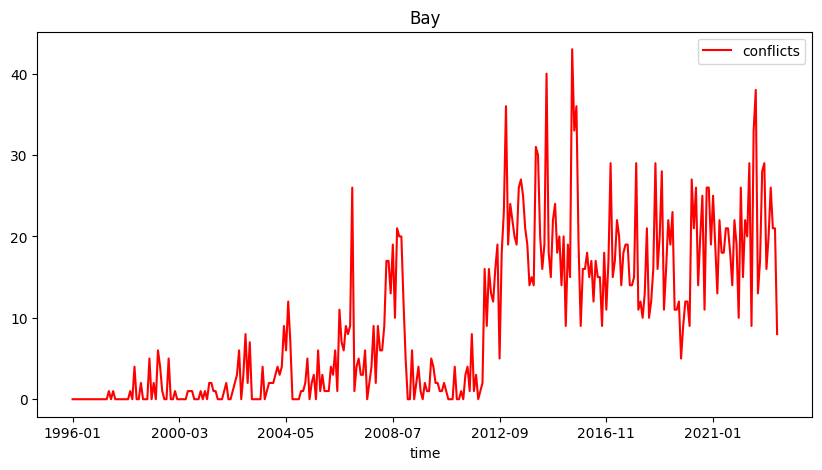

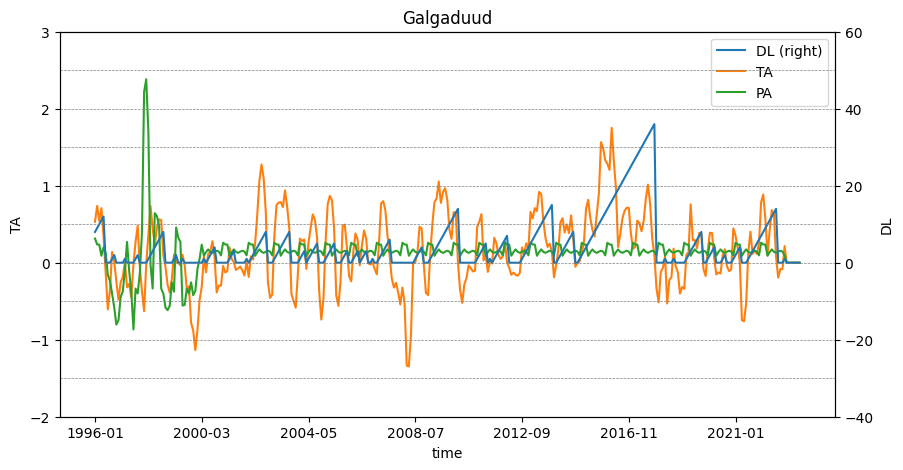

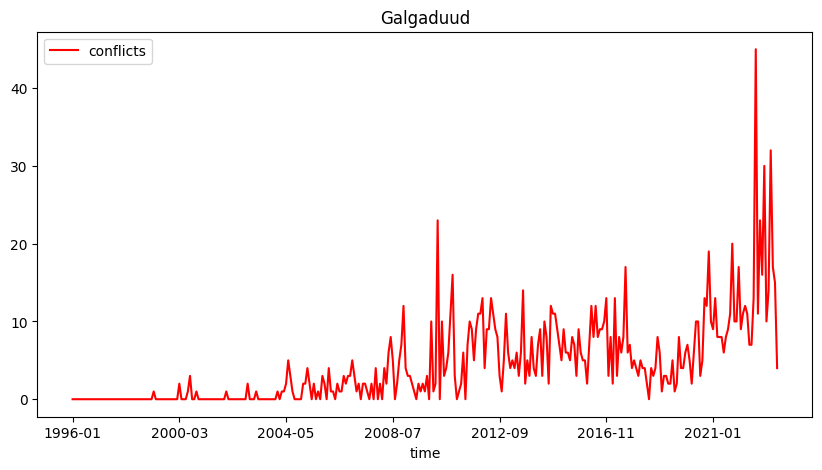

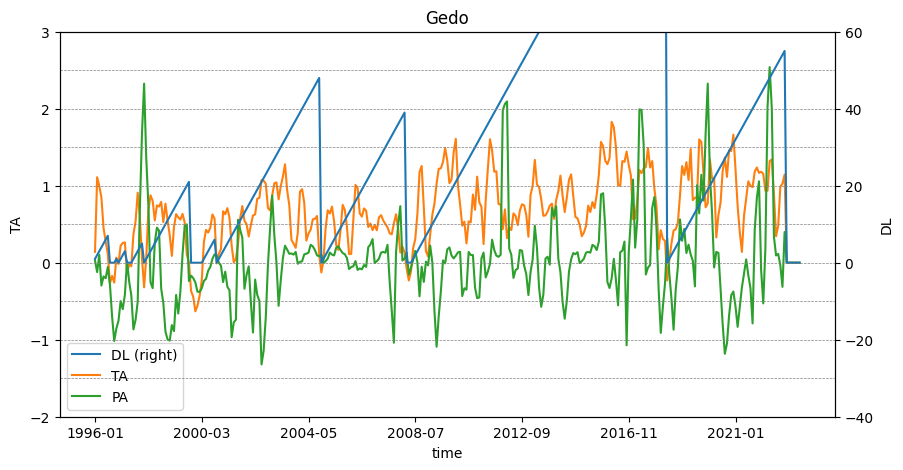

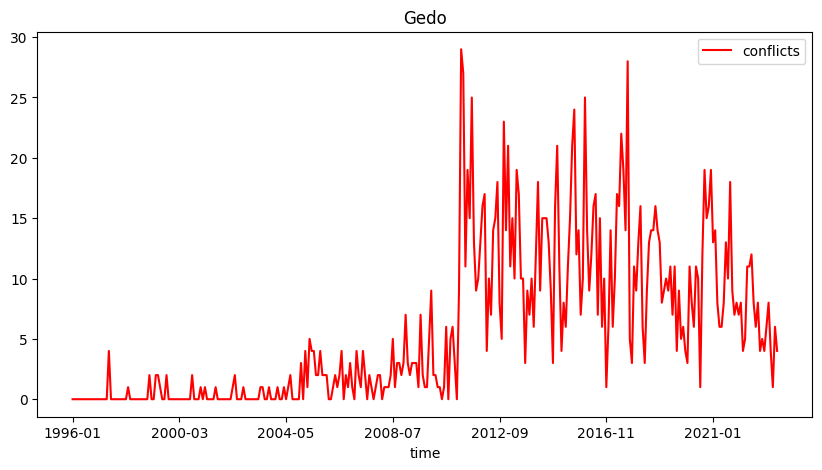

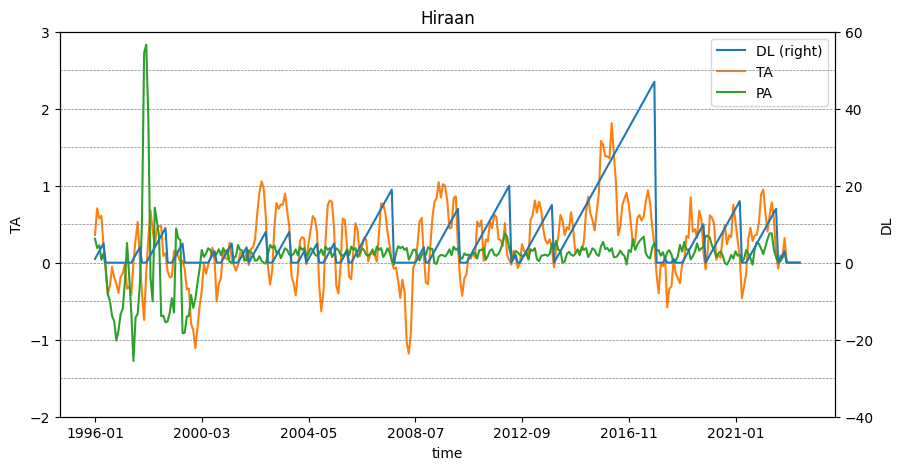

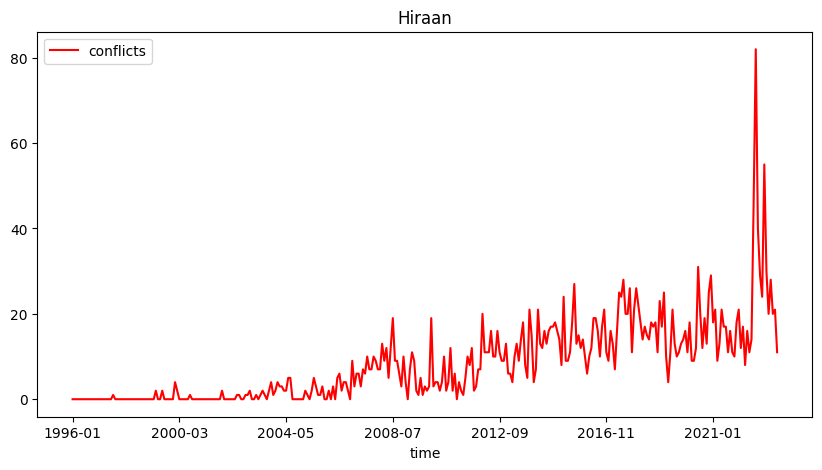

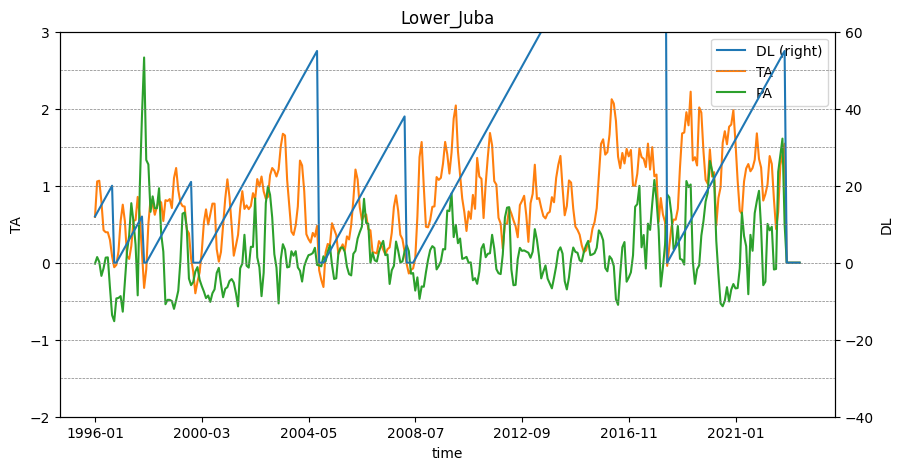

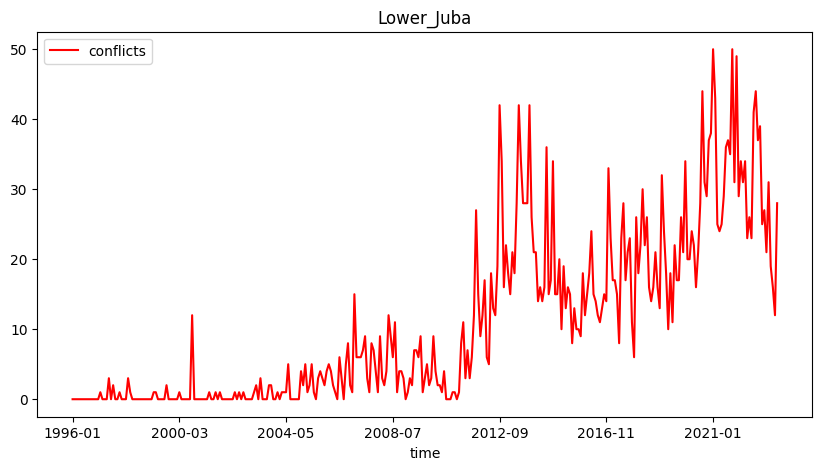

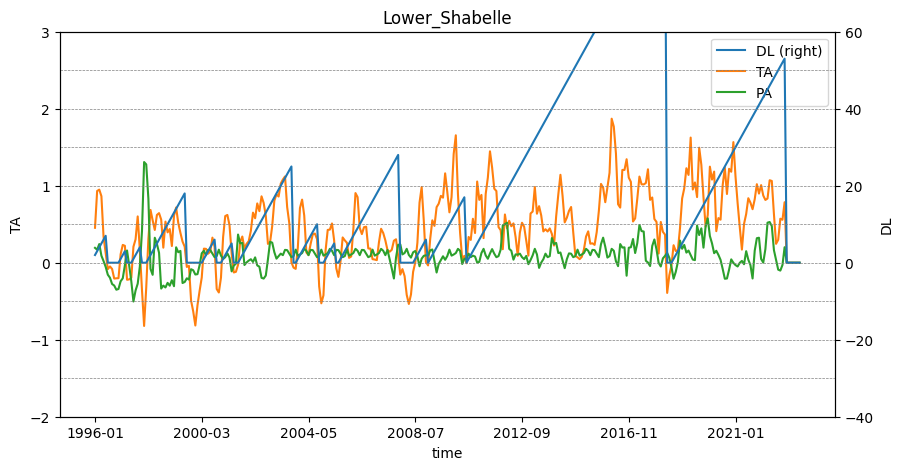

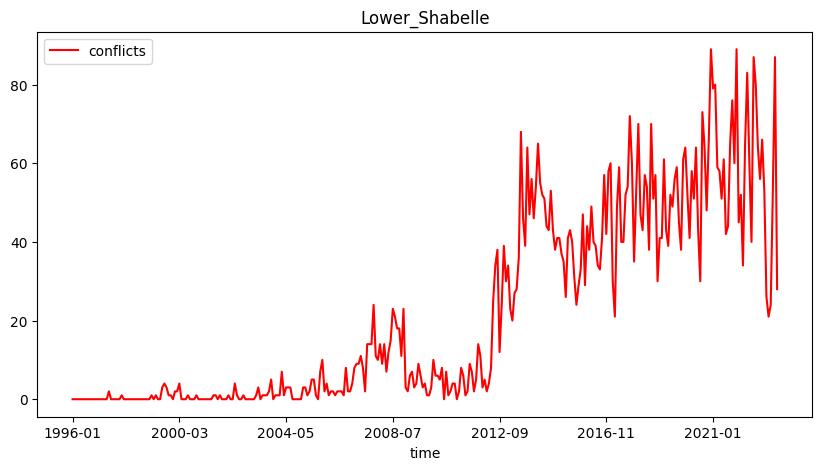

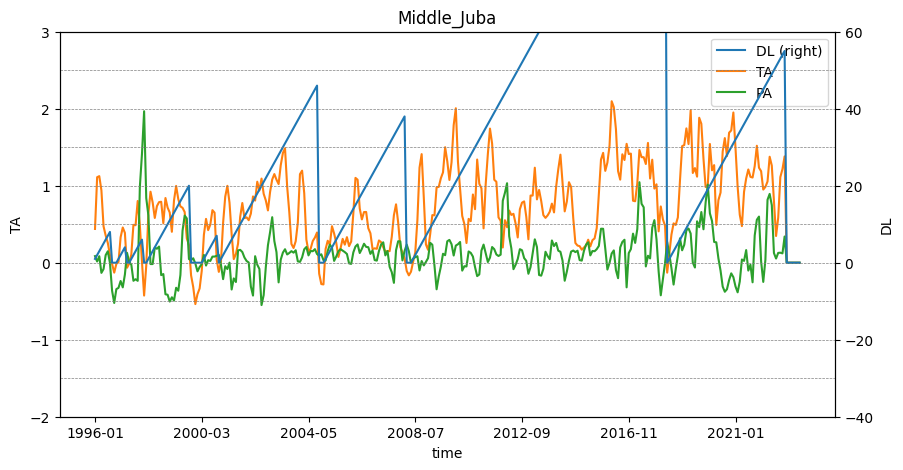

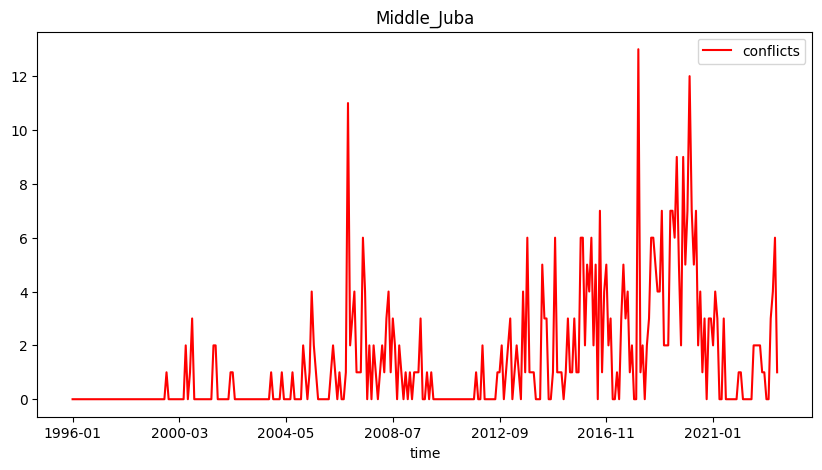

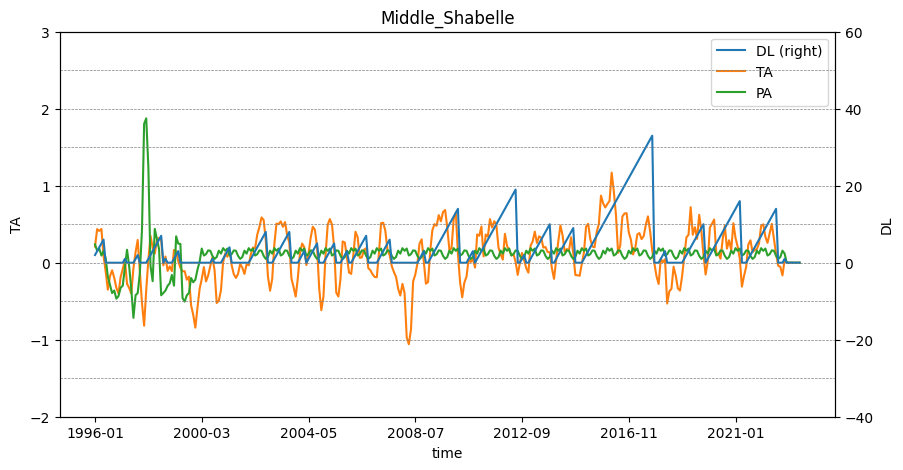

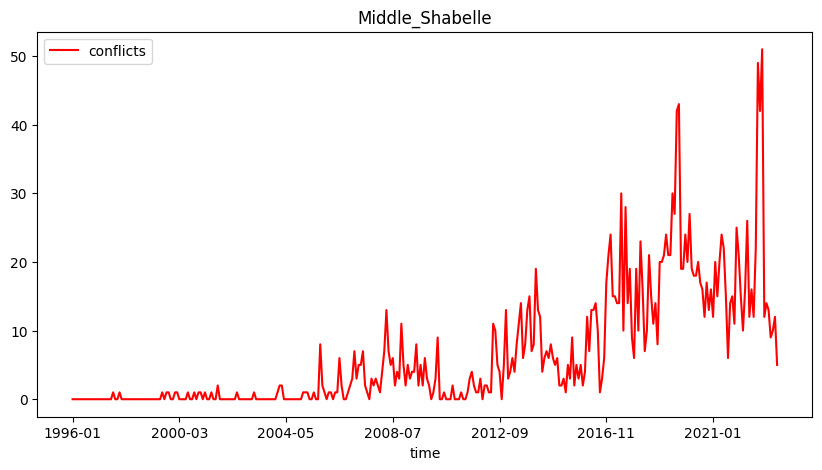

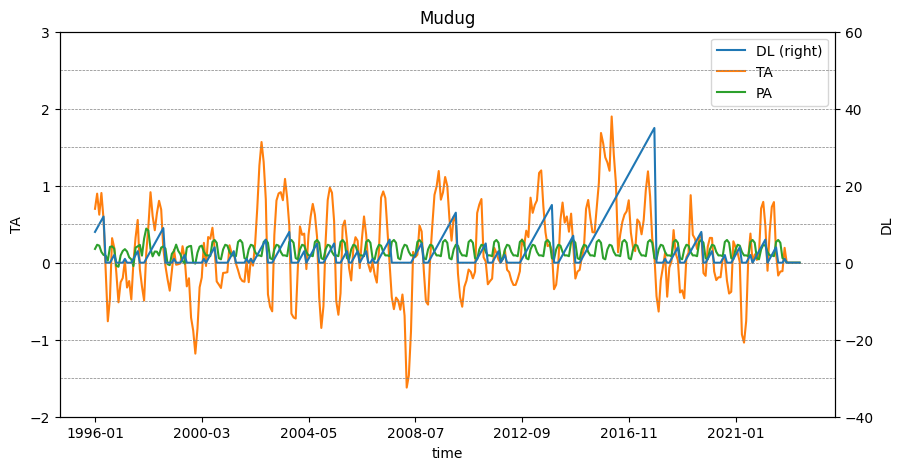

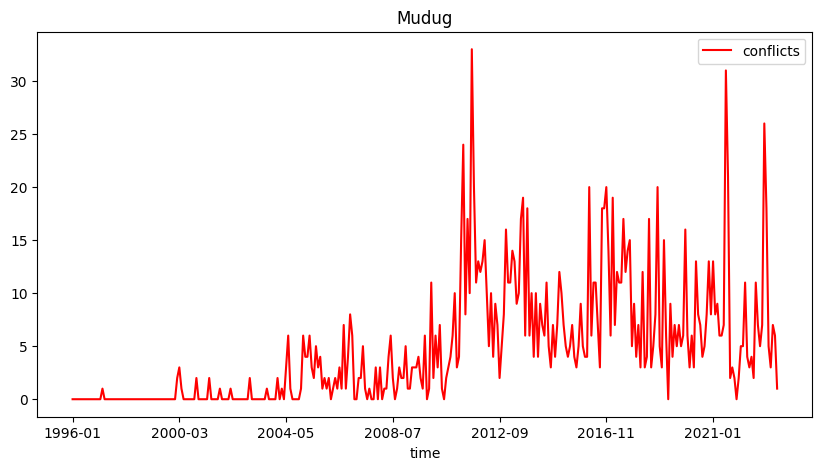

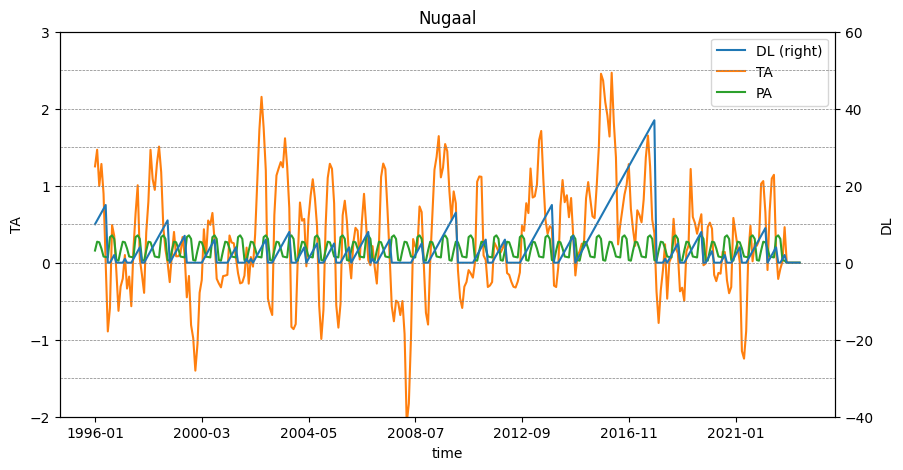

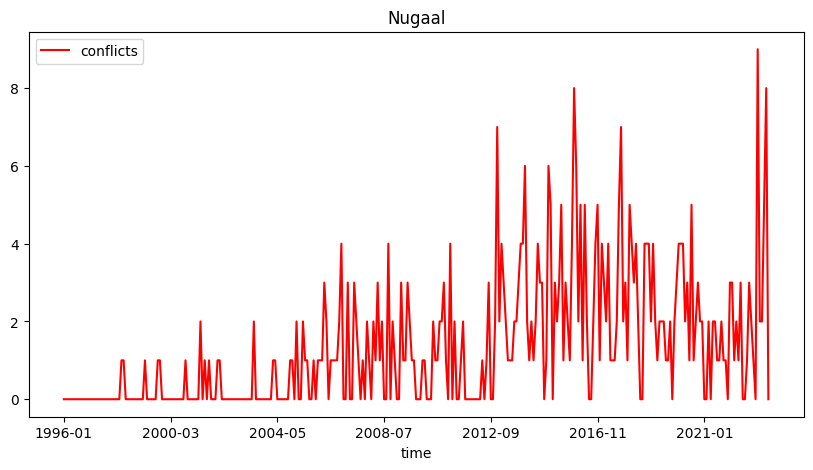

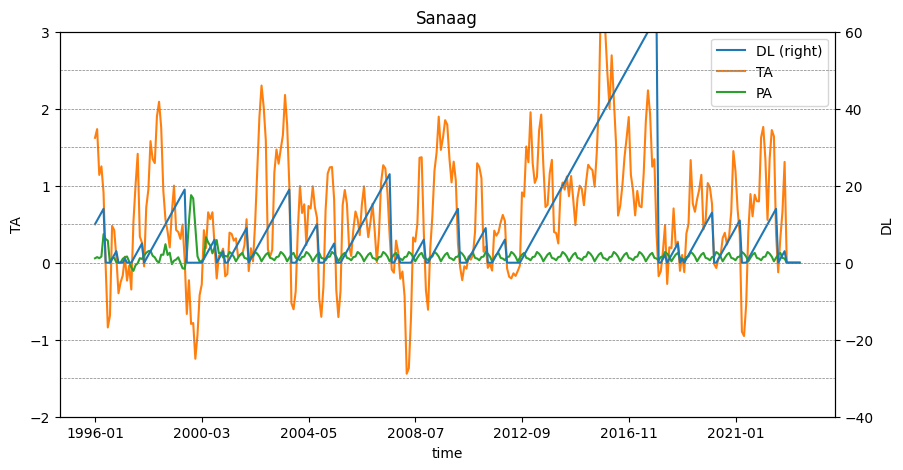

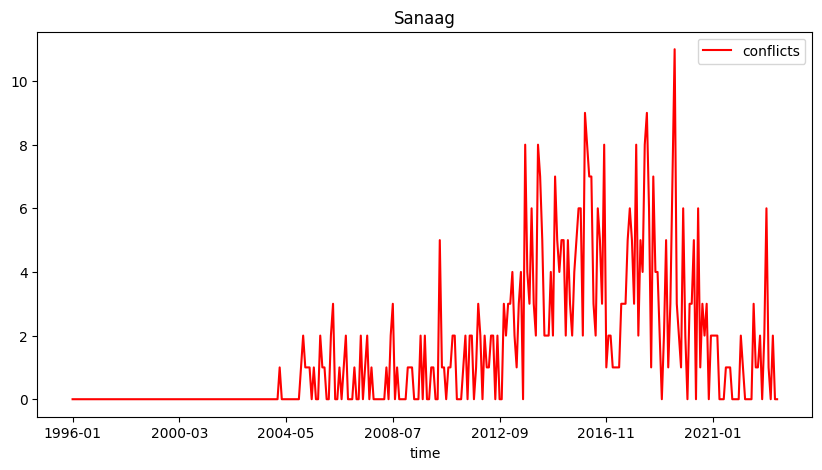

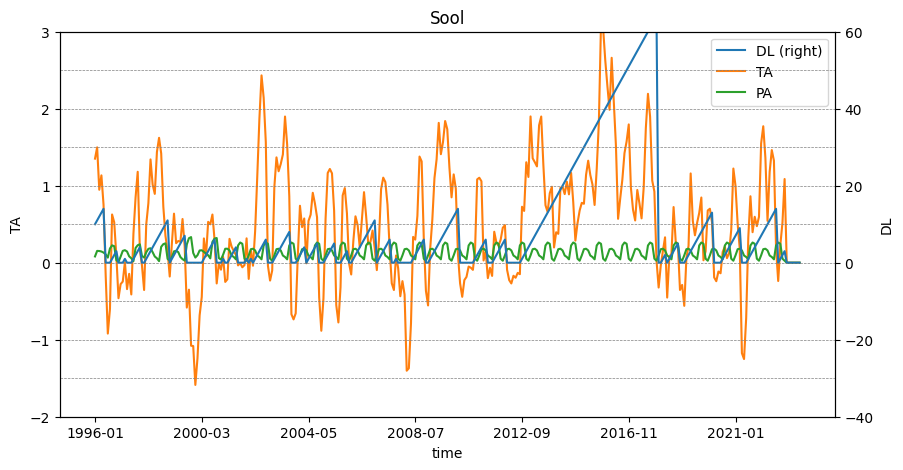

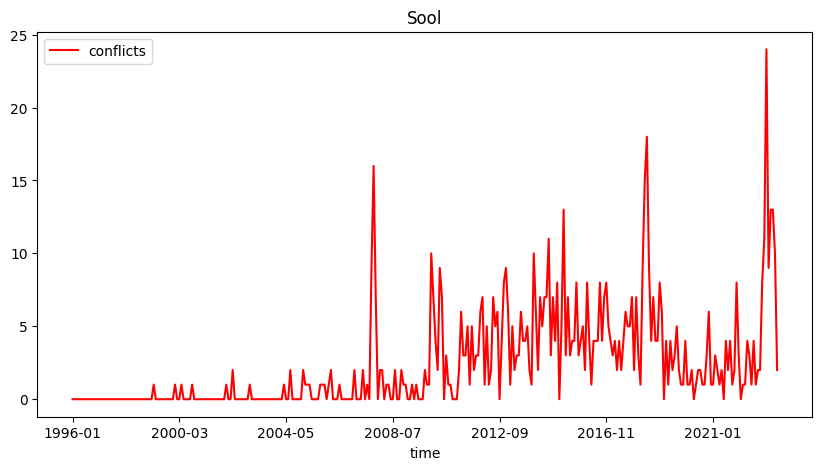

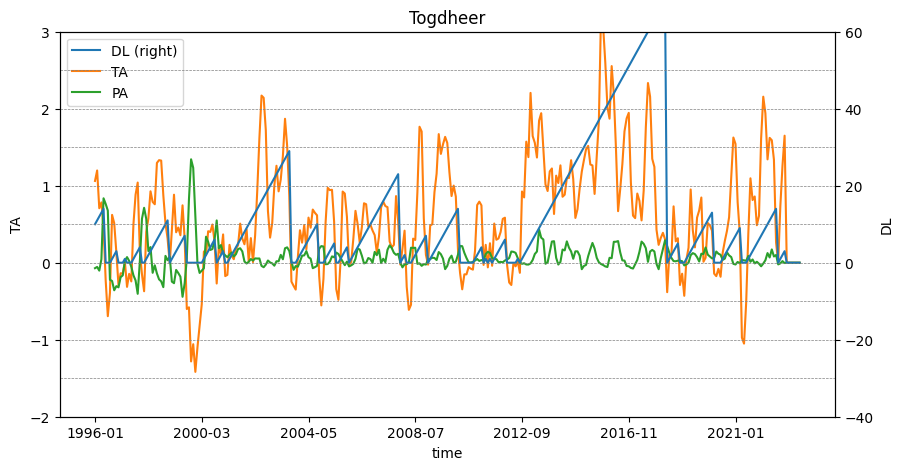

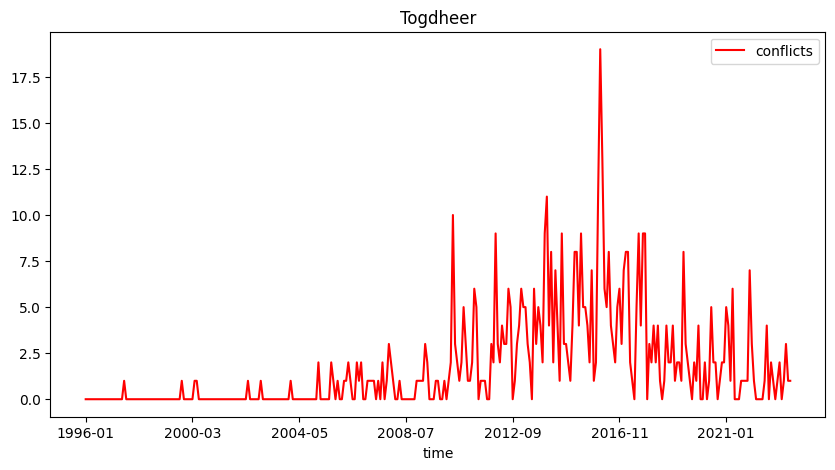

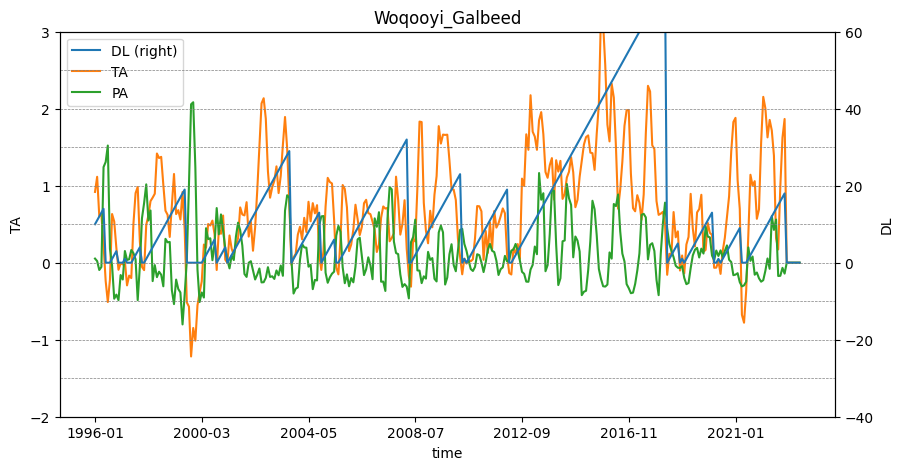

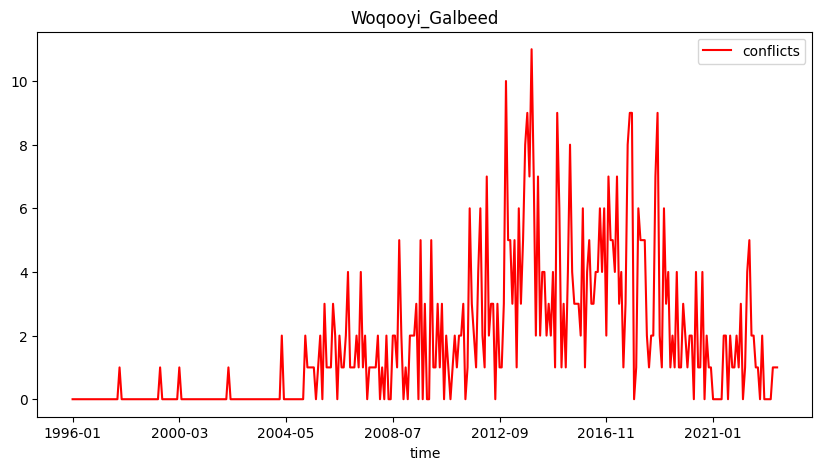

In [27]:
# plot variables DL and TA against time

for regi in df_c_97_09['admin1'].unique():
    ap = df_c_97_09[df_c_97_09['admin1']==regi]
    aw = ap[['time','DL','TA','PA']]
    aw = aw.set_index('time')

    ax = aw.plot(secondary_y='DL', mark_right=True, figsize=(10,5))
    ax.set_ylabel('TA')
    ax.right_ax.set_ylabel('DL')
    ax.set_ylim(-2, 3)
    ax.right_ax.set_ylim(-40, 60)
    plt.title(regi)
    for i in range(-4, 6):
        plt.axhline(y=i*10, color='grey', linestyle='--', linewidth=0.5)
    plt.show()
    ay = ap[['time','conflicts']]
    ay = ay.set_index('time')
    ay.plot(color='red', mark_right=True, figsize=(10,5)) 
    plt.title(regi)
    plt.show()

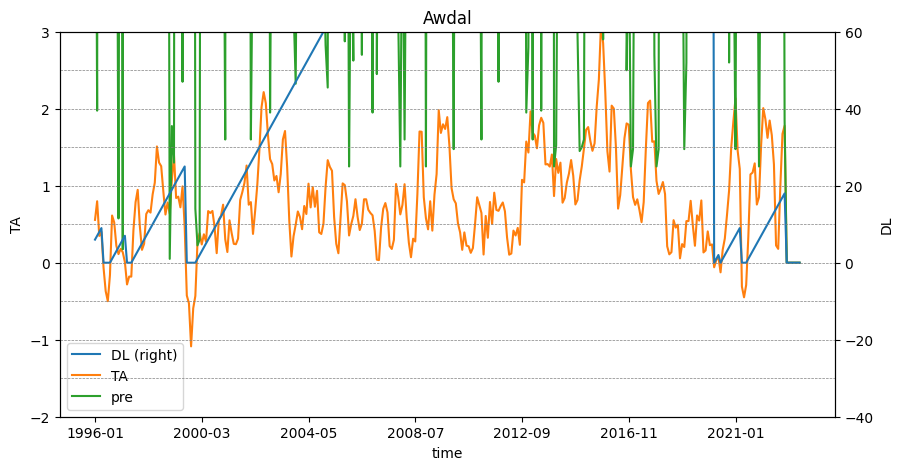

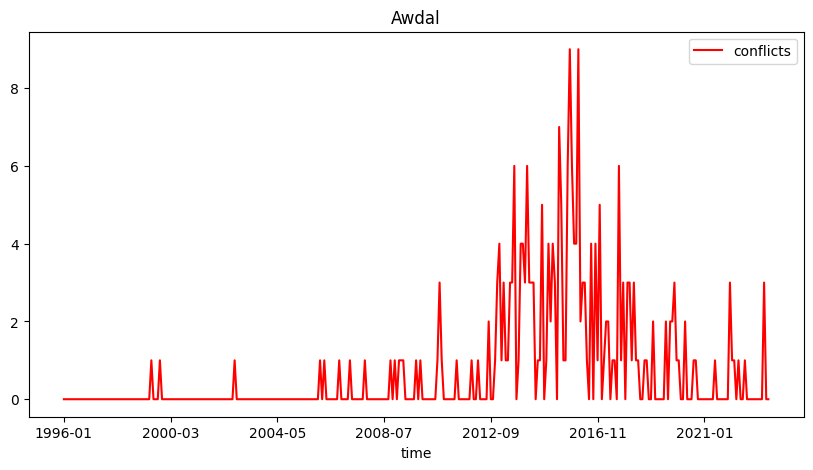

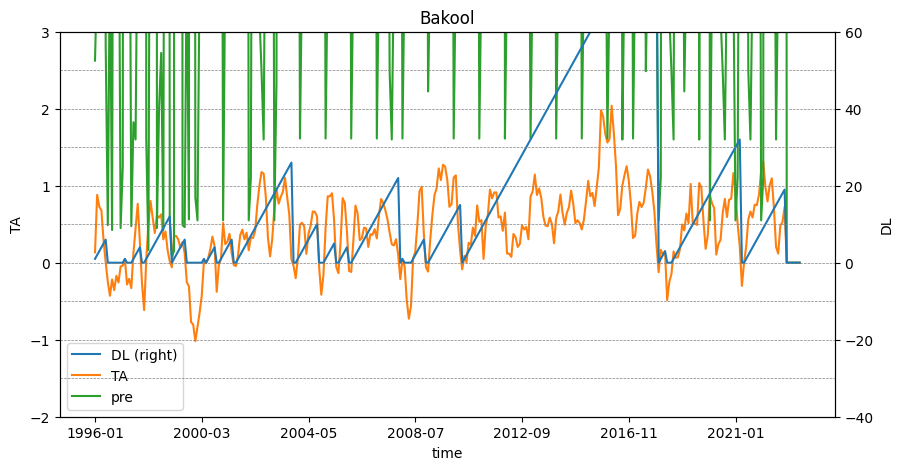

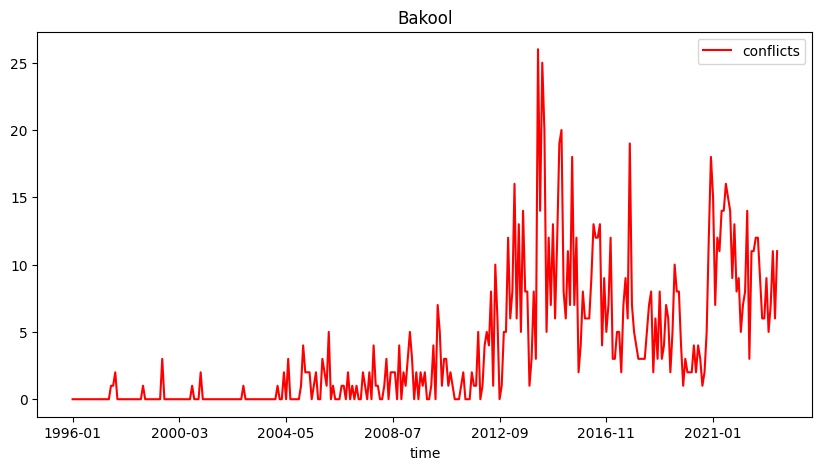

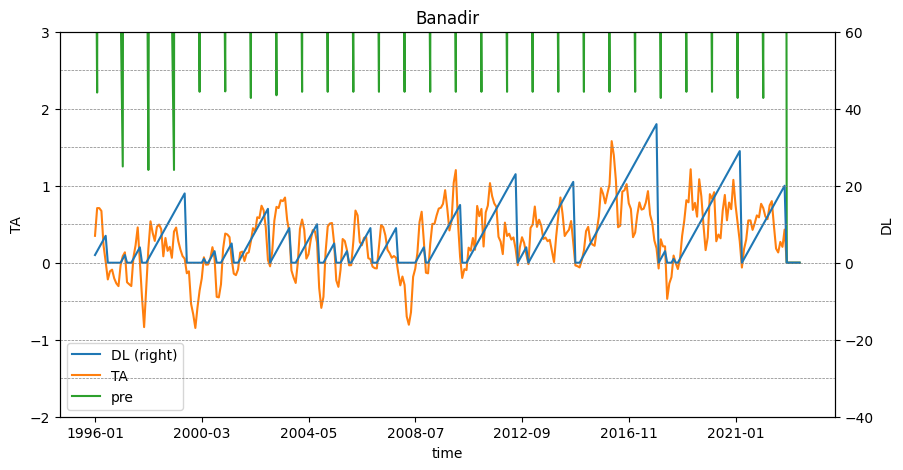

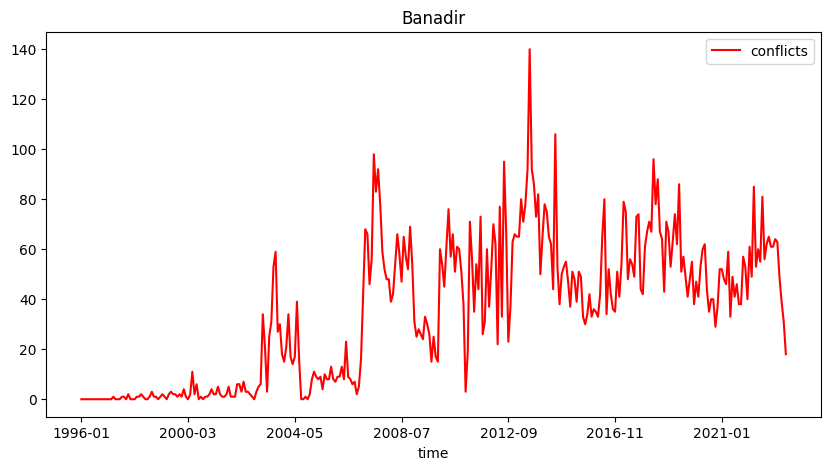

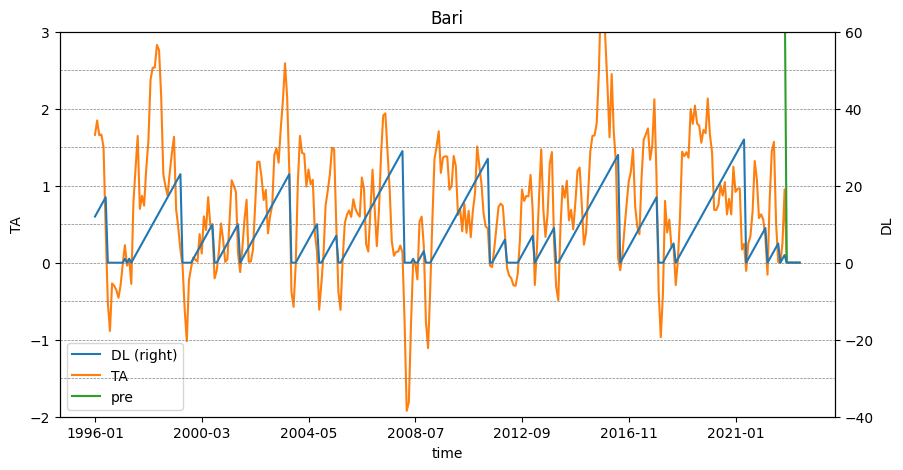

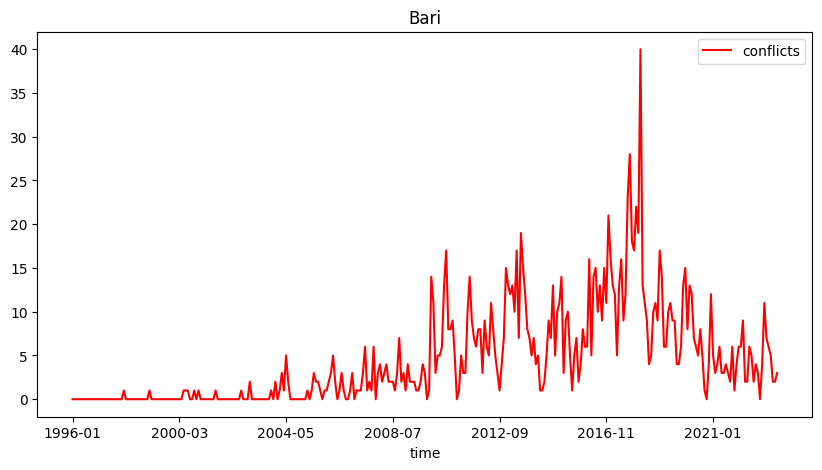

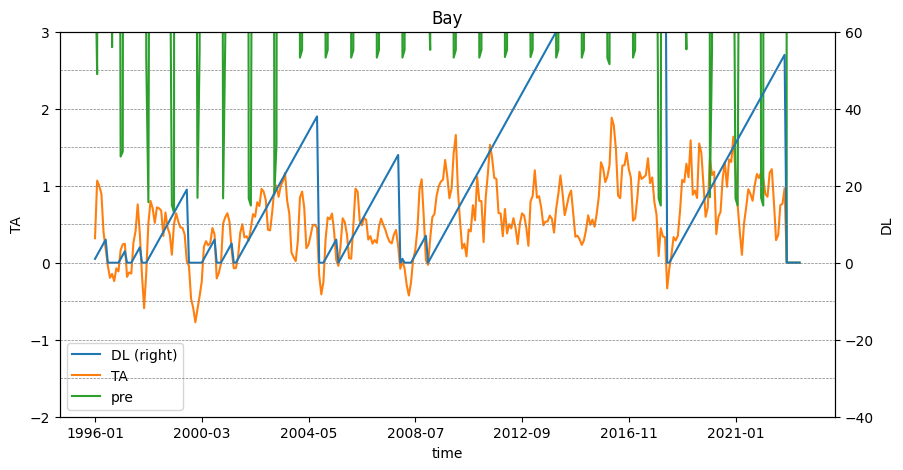

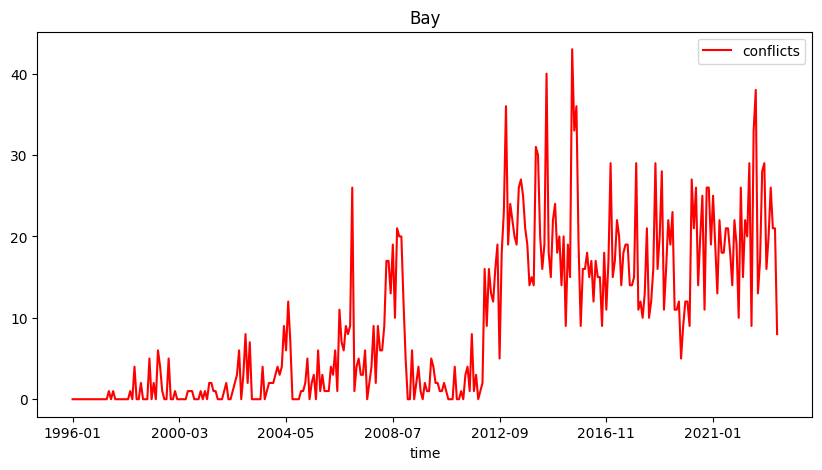

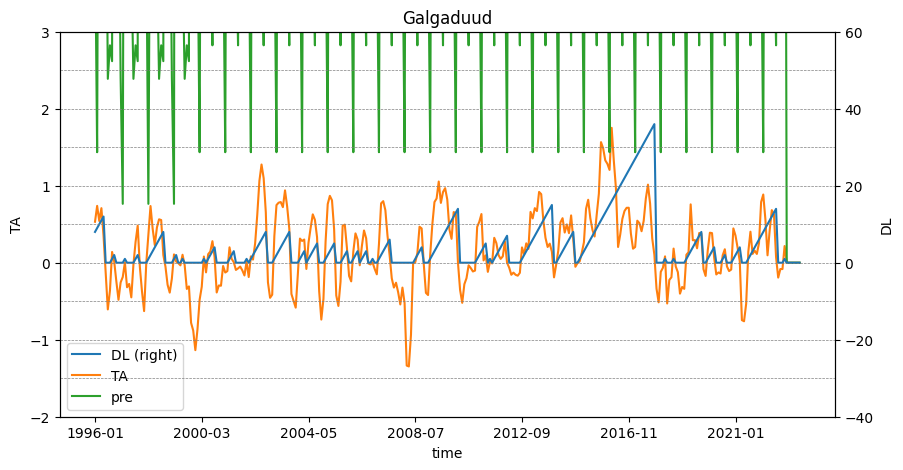

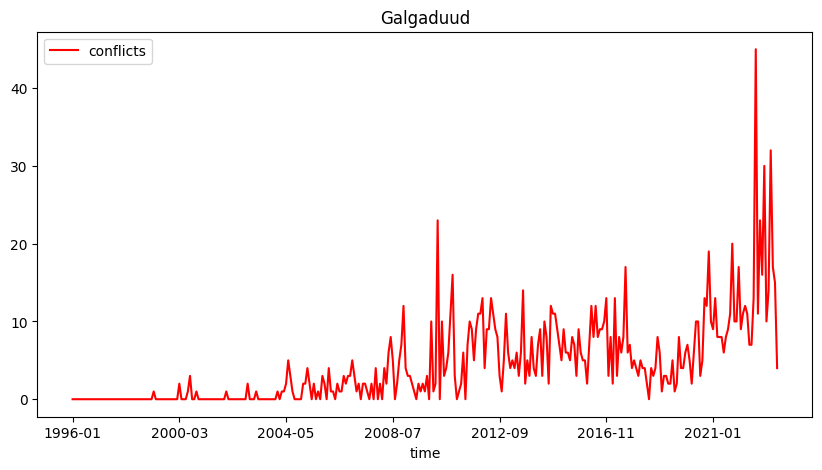

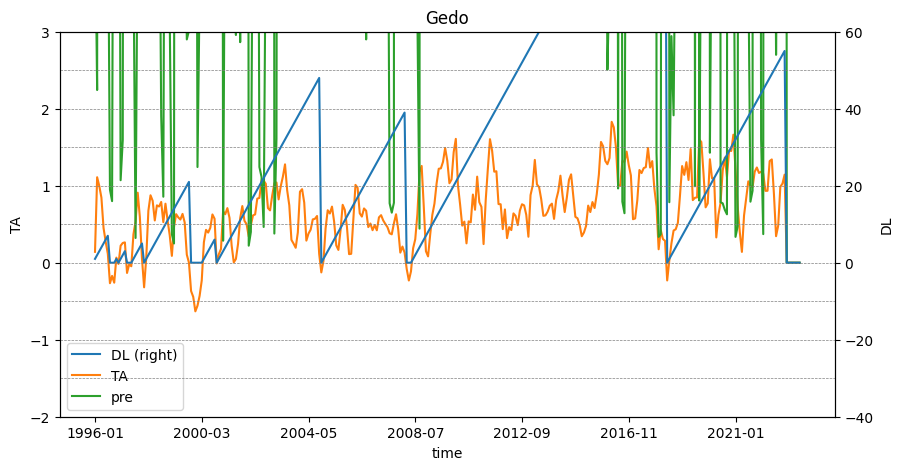

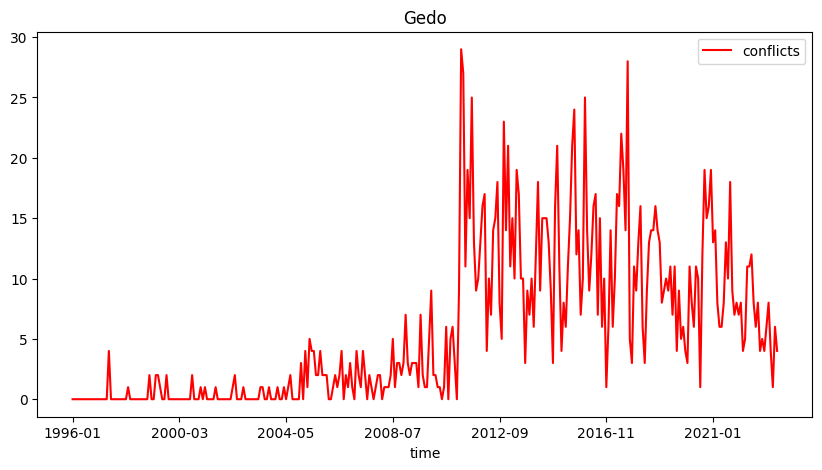

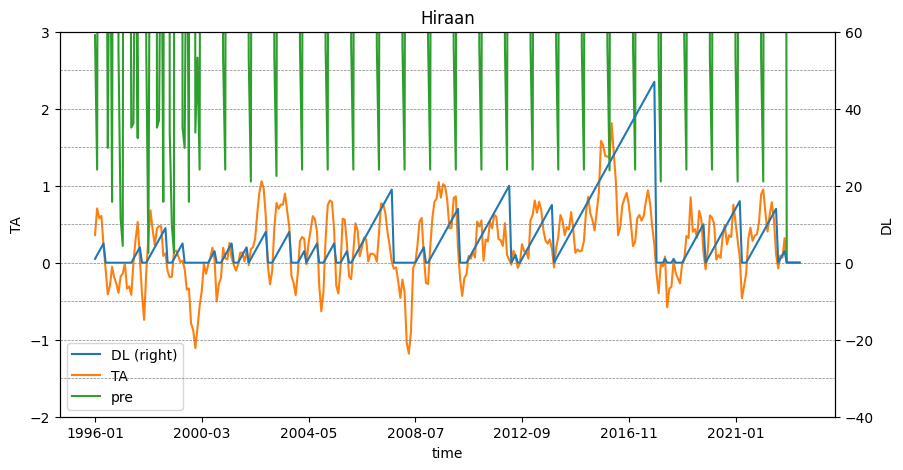

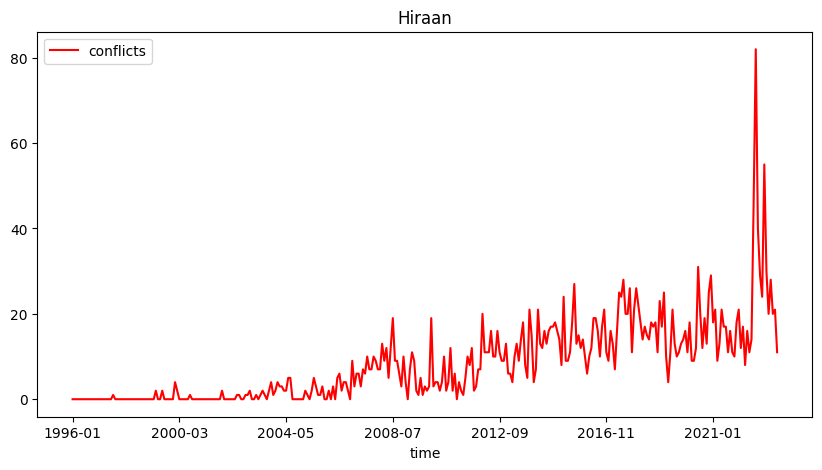

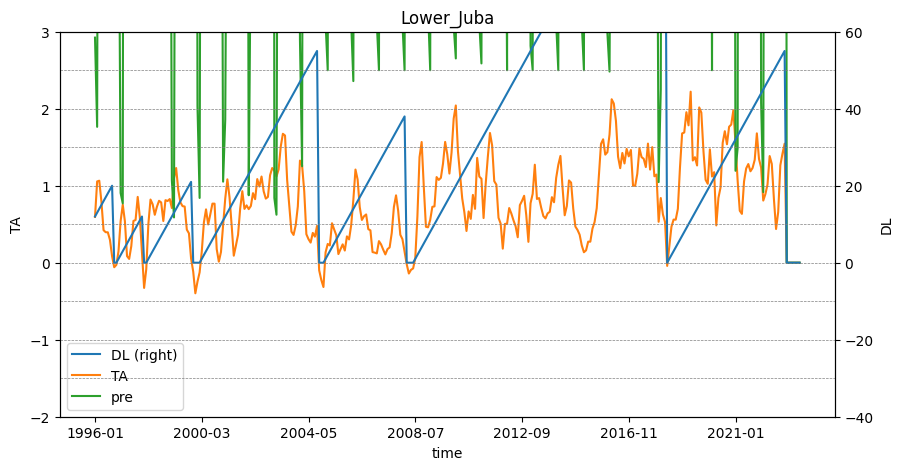

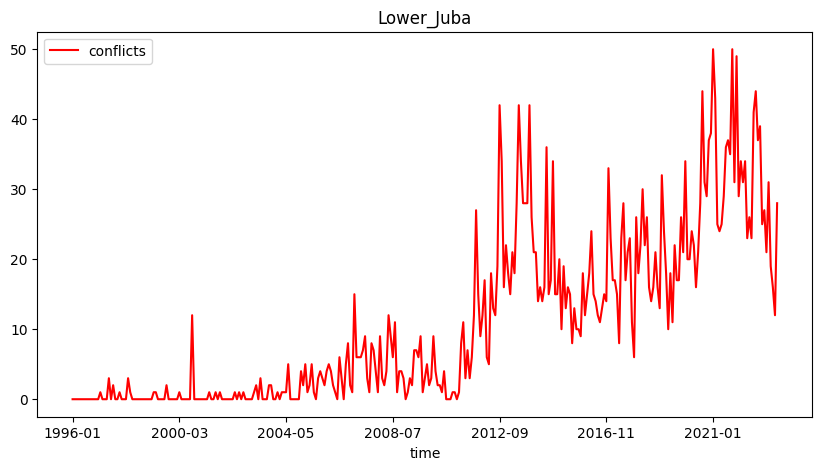

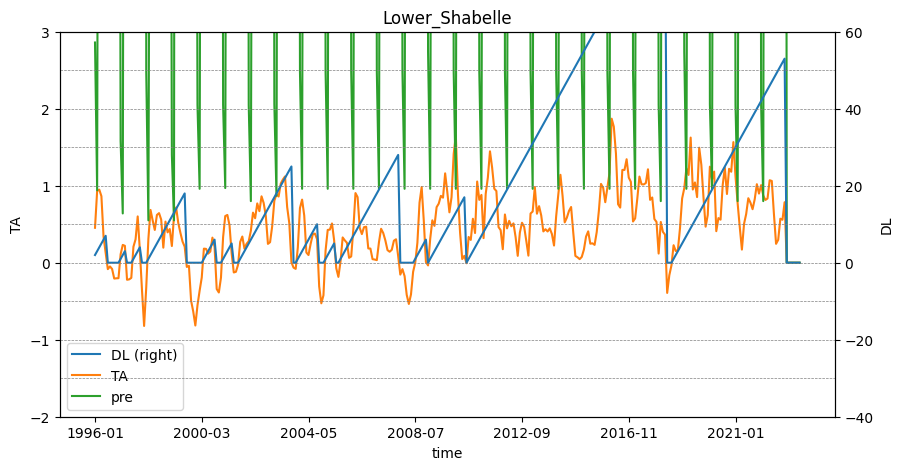

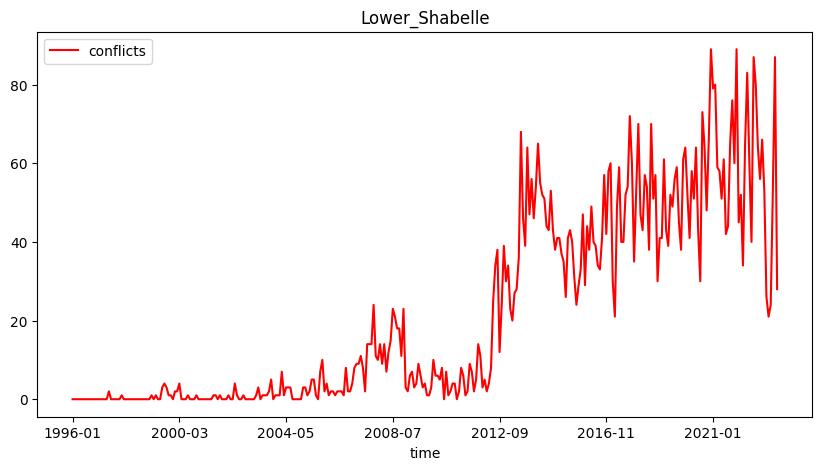

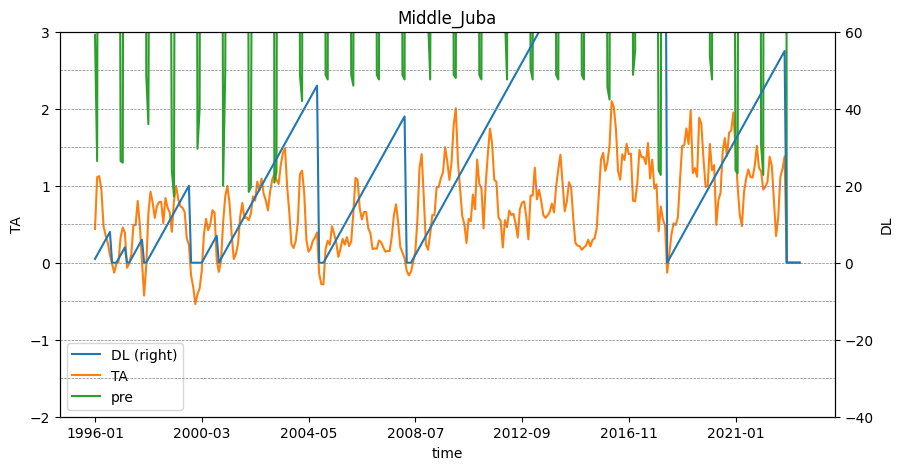

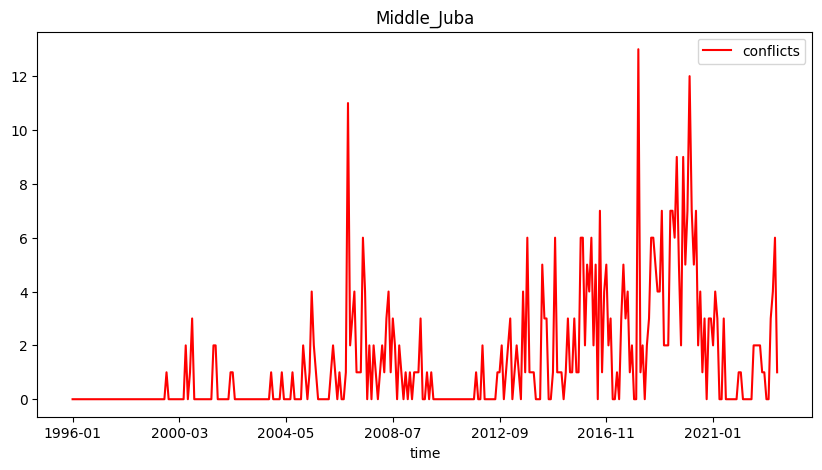

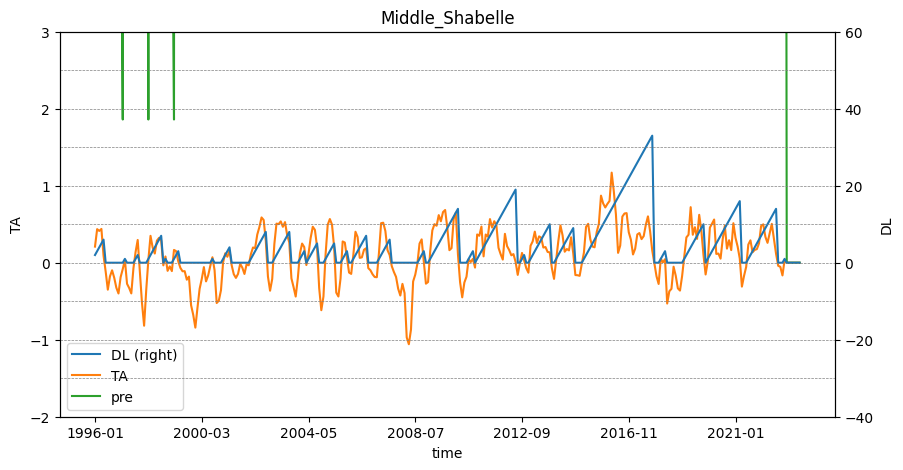

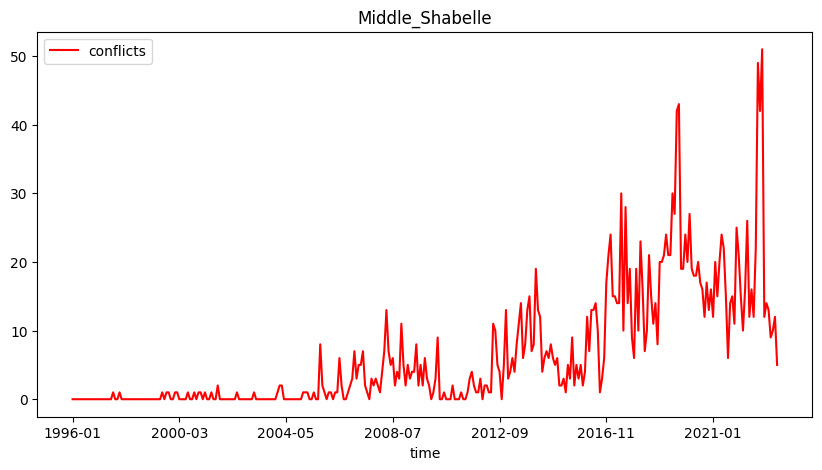

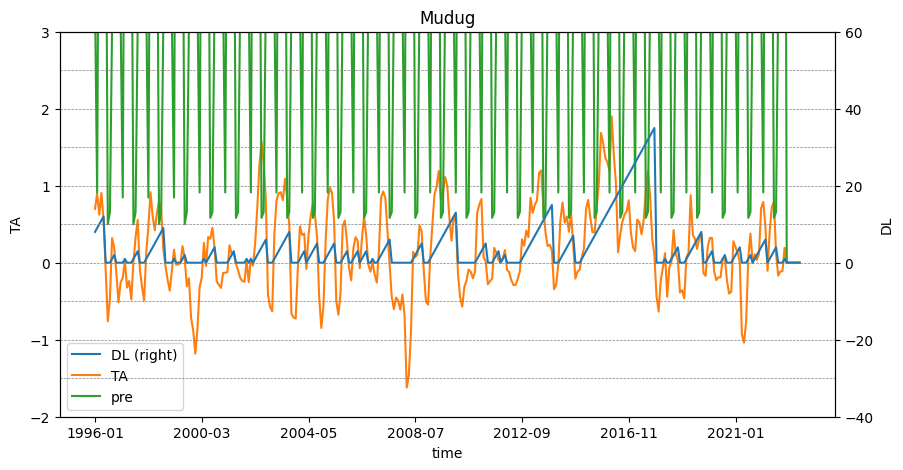

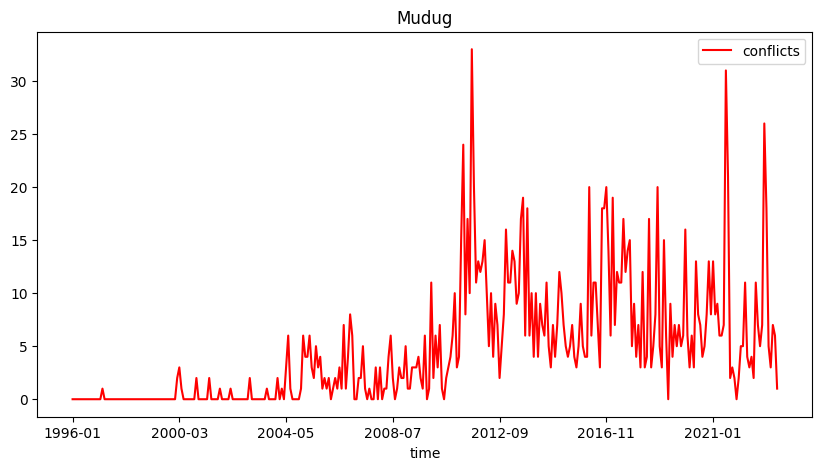

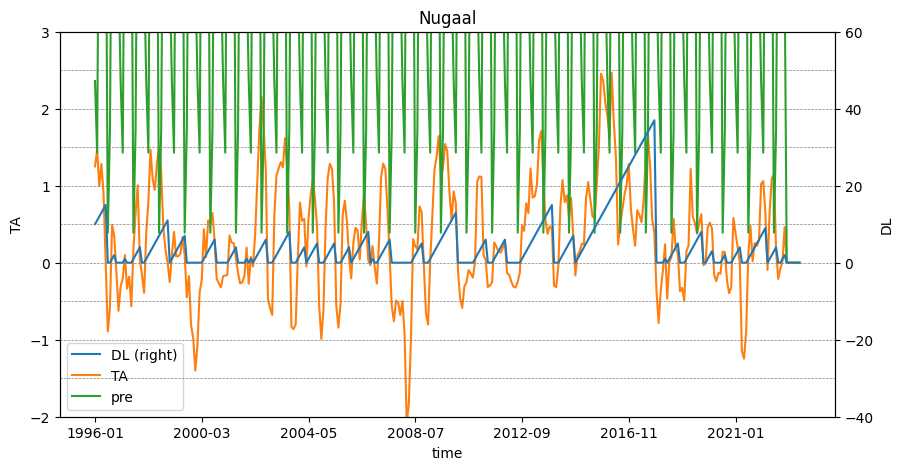

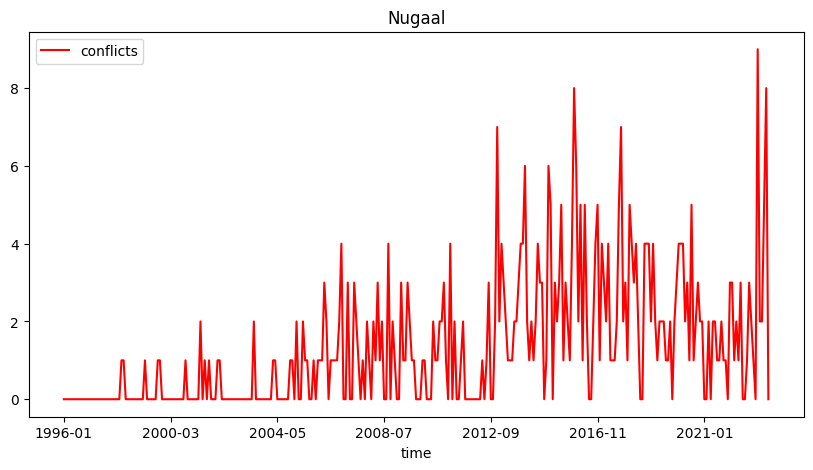

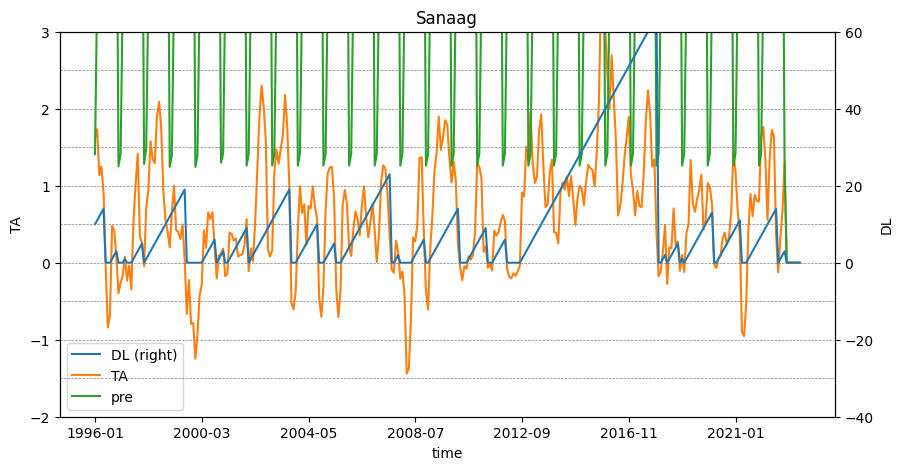

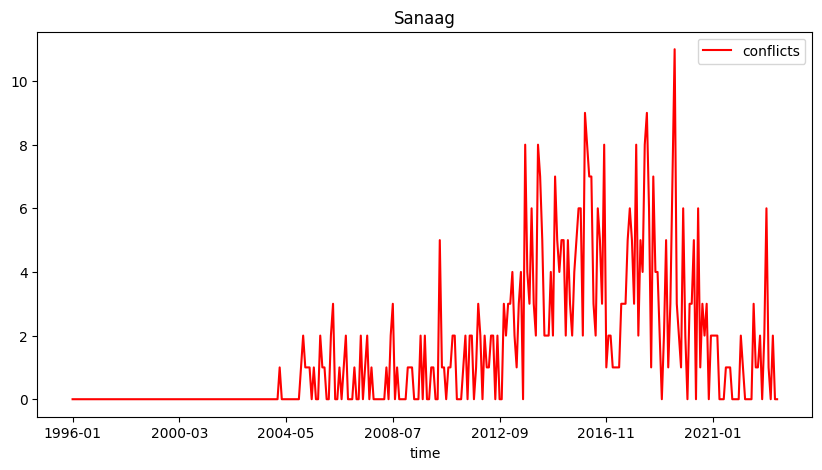

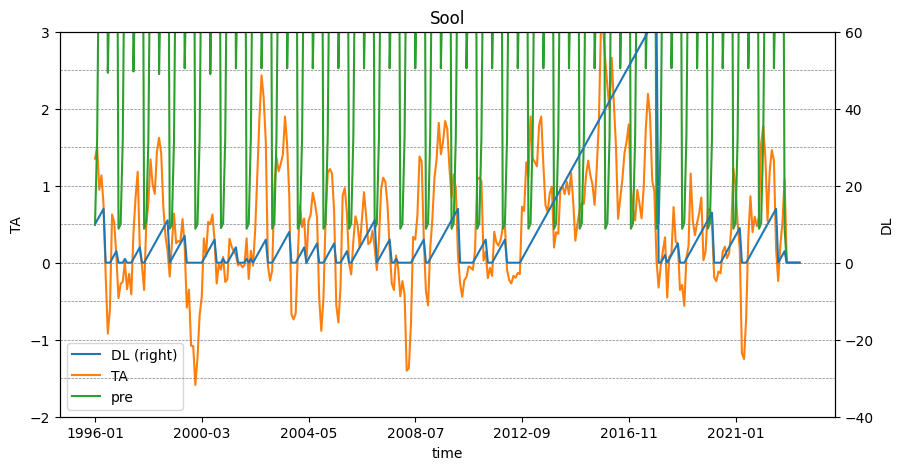

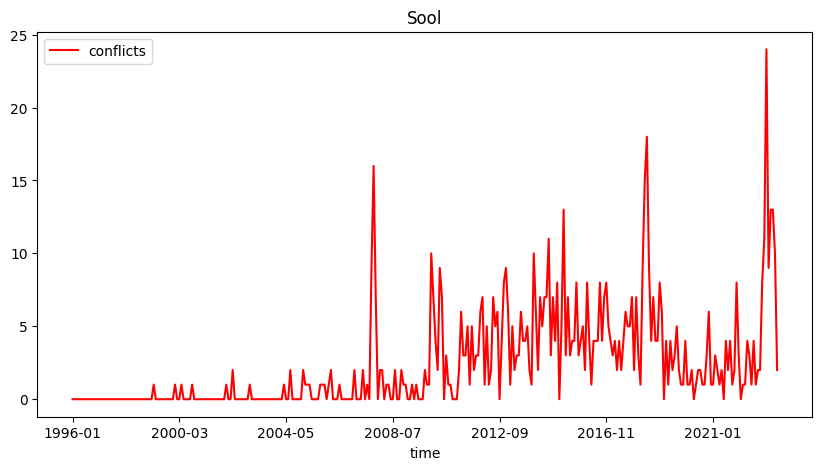

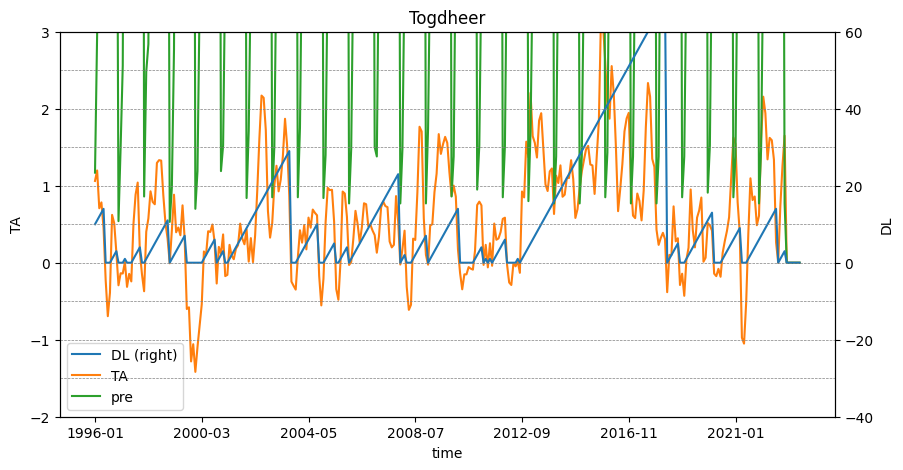

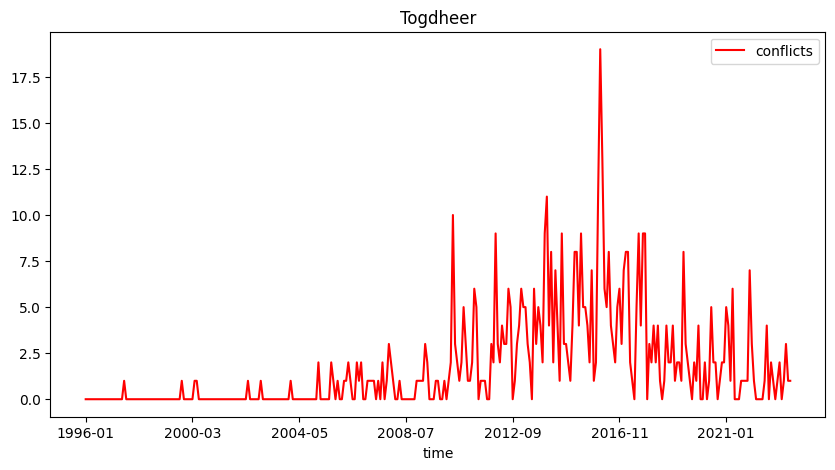

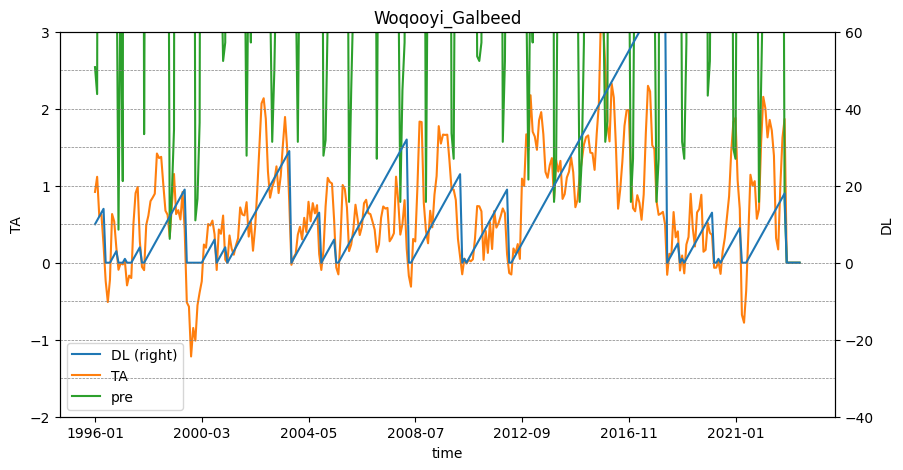

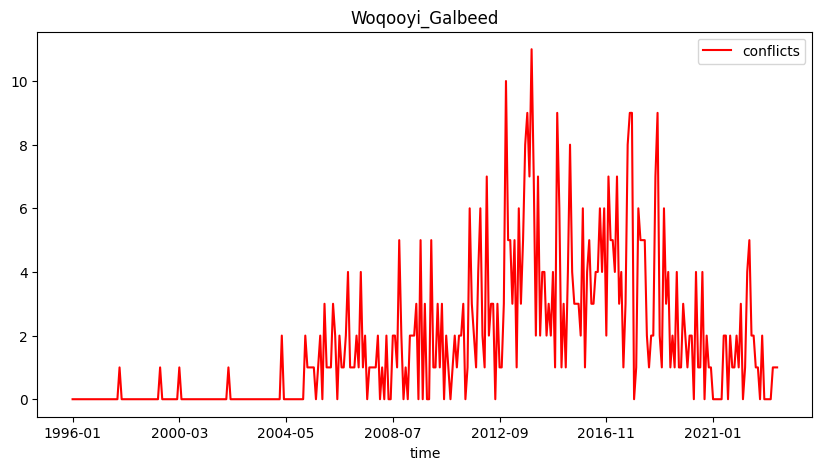

In [28]:
for regi in df_c_97_09['admin1'].unique():
    ap = df_c_97_09[df_c_97_09['admin1']==regi]
    aw = ap[['time','DL','TA','pre']]
    aw = aw.set_index('time')

    ax = aw.plot(secondary_y='DL', mark_right=True, figsize=(10,5))
    ax.set_ylabel('TA')
    ax.right_ax.set_ylabel('DL')
    ax.set_ylim(-2, 3)
    ax.right_ax.set_ylim(-40, 60)
    plt.title(regi)
    for i in range(-4, 6):
        plt.axhline(y=i*10, color='grey', linestyle='--', linewidth=0.5)
    plt.show()
    ay = ap[['time','conflicts']]
    ay = ay.set_index('time')
    ay.plot(color='red', mark_right=True, figsize=(10,5)) 
    plt.title(regi)
    plt.show()

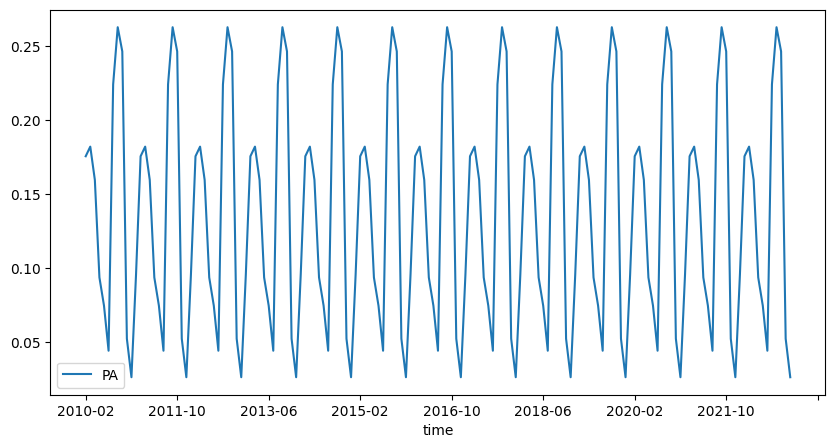

In [50]:
#limit x range
reg[15]=reg[15][reg[15]['time']>'2010-01-01']
reg[15].plot(x='time', y='PA', figsize=(10,5))
#print all array
np.set_printoptions(threshold=np.inf)
aaa=reg[15]['PA']

In [51]:
df_c_97_09['admin1'].unique()

array(['Awdal', 'Bakool', 'Banadir', 'Bari', 'Bay', 'Galgaduud', 'Gedo',
       'Hiraan', 'Lower_Juba', 'Lower_Shabelle', 'Middle_Juba',
       'Middle_Shabelle', 'Mudug', 'Nugaal', 'Sanaag', 'Sool', 'Togdheer',
       'Woqooyi_Galbeed'], dtype=object)